In [1]:
!pip install pygame
!pip install gym==0.26.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordEpisodeStatistics
gymlogger.set_level(40) #error only
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode

from IPython import display as ipythondisplay
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [4]:
gym.__version__

'0.26.2'

In [ ]:
def show_video(episode):
  mp4 = open(f'/content/videos/0.25.2/rl-video-episode-{episode}.mp4','rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  ipythondisplay.display(HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url))

In [5]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode = "rgb_array")

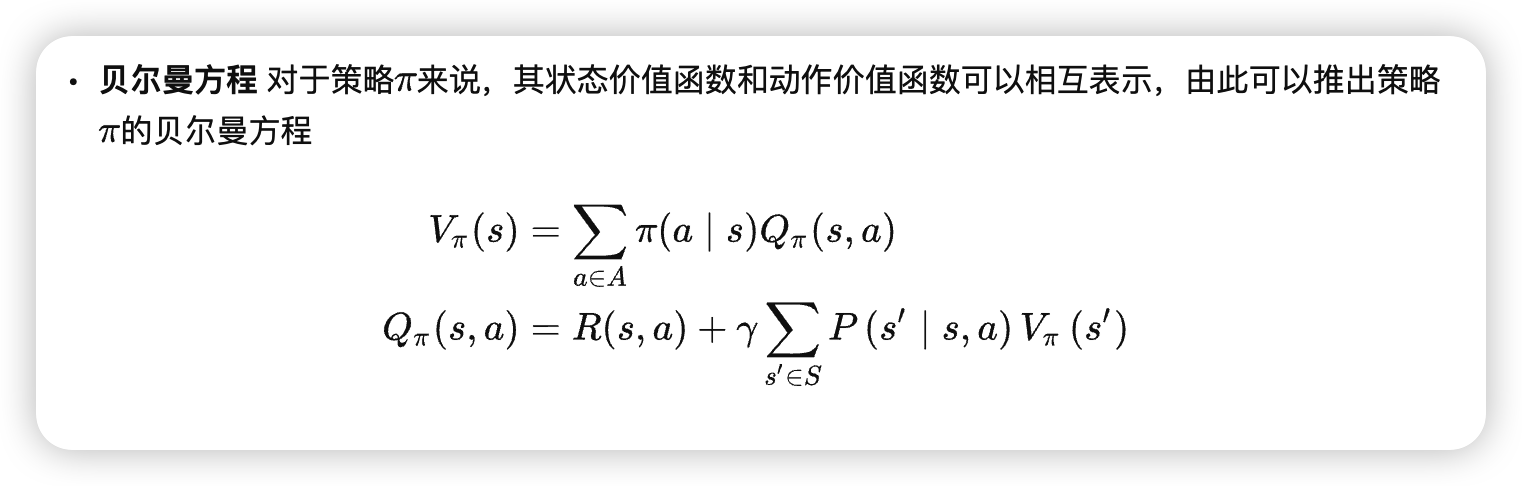

参考https://zhuanlan.zhihu.com/p/496774565?utm_id=0<br>
相较于is_slippery=Fals的情况，Q表的更新方式需要考虑侧滑的概率与侧滑的Q值，参考def **learn**(self, s, a, r, s_)方法的区别

In [7]:
class QLearningTable:
  def __init__(self, actions, terminal, slipper_actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.1):
    self.actions = actions
    self.lr = learning_rate
    self.gamma = reward_decay
    self.epsilon = e_greedy
    self.q_table = pd.DataFrame(columns = self.actions, dtype=np.float64)
    self.terminal = terminal
    self.slipper_actions = slipper_actions

  def choose_action(self, observation, is_test):
    self.check_state_exist(observation)


    if np.random.uniform()>self.epsilon or is_test==True:
      state_action = self.q_table.loc[observation, :]
      action = np.random.choice(state_action[state_action == np.max(state_action)].index)
    else:
      action = np.random.choice(self.actions)
    return action

  def learn(self, s, a, r, s_):
    q_target_sum = 0
    for i in self.slipper_actions[a]:
      temp_s = s + i
      temp_s = max(0, temp_s)
      temp_s = min(15, temp_s)
      self.check_state_exist(temp_s)
      if temp_s != self.terminal:
        q_target_sum += r+self.gamma*self.q_table.loc[temp_s, :].max()
      else:
        q_target_sum += r
    q_predict = self.q_table.loc[s, a]
    q_target_sum /= 3
    self.q_table.loc[s, a] += self.lr*(q_target_sum-q_predict)
    # print(self.q_table.loc[s, a])



  def check_state_exist(self, state):
    # print(self.q_table)
    if state not in self.q_table.index:
      self.q_table.loc[state] = [0]*len(self.actions)

In [47]:
#侧滑对应的所有方向
slipper_actions = {}
slipper_actions[0] = [-1, 4, -4]
slipper_actions[1] = [-1, 4, 1]
slipper_actions[2] = [4, 1, -4]
slipper_actions[3] = [-1, 1, -4]
RL = QLearningTable(range(4), 15, slipper_actions, learning_rate=0.5, e_greedy=0.8)

In [39]:
#test
def get_test_accuracy(RL, test_total_episode):
  test_success = 0
  for episode in range(test_total_episode):
    observation, info = env.reset()
    while True:
      env.render()
      action = RL.choose_action(observation, True)
      observation_, rewards, terminated, truncated, infos = env.step(action)
      observation = observation_
      if terminated:
        if observation == 15:
          test_success += 1
        break
  return (test_success/test_total_episode)

In [48]:
success = 0
total_episode = 10000
test_episode = 100
list_accuracy = []
for episode in range(total_episode):
  observation, info = env.reset()
  while True:
    env.render()
    action = RL.choose_action(observation, False)
    observation_, rewards, terminated, truncated, infos = env.step(action)
    if terminated and observation_ != 15:
      rewards = -1
    else:
      rewards *= 2
    RL.learn(observation, action, rewards, observation_)
    observation = observation_
    # print(RL.q_table)
    if terminated:
      if observation == 15:
        # print("success")
        # print(RL.q_table)
        success += 1
      break
  if (episode+1)%100 == 0:
    accuracy = get_test_accuracy(RL, test_episode)
    list_accuracy.append([episode+1, accuracy])

In [62]:
RL.q_table

,0,1,2,3
0,0.057444,0.053629,0.053632,0.047866
1,-0.406489,-0.246238,-0.477001,0.045339
2,-0.071573,-0.003300,0.000702,0.041474
3,-0.108574,-0.109791,0.009560,0.045577
7,0.000000,0.000000,0.000000,0.000000
4,0.078042,0.058722,-0.499057,-0.100396
6,-0.108181,-0.800993,-0.436320,-0.232359
10,0.654877,0.429917,-0.207993,-0.146040
8,0.020606,-0.149003,0.152728,0.158703
12,0.000000,0.000000,0.000000,0.000000


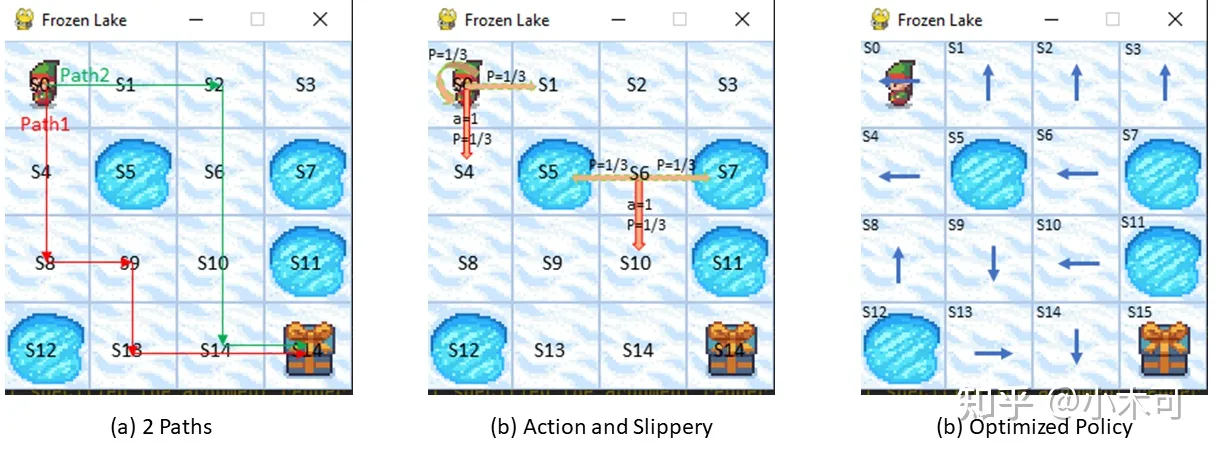

可知, 在这种给定策略,有82.4%的概率到达目标点 
参考：https://zhuanlan.zhihu.com/p/554765525?utm_id=0

In [65]:
#0: LEFT
#1: DOWN
#2: RIGHT
#3: UP
best_action_list = []
action_map = {0:"⬅️", 1:"⬇️", 2:"➡️", 3:"⬆️"}
for i in range(16):
  state_action = RL.q_table.loc[i, :]
  best_action = np.random.choice(state_action[state_action == np.max(state_action)].index)

  best_action_list.append([i, action_map[best_action]])
print(best_action_list)

[[0, '⬅️'], [1, '⬆️'], [2, '⬆️'], [3, '⬆️'], [4, '⬅️'], [5, '⬆️'], [6, '⬅️'], [7, '⬆️'], [8, '⬆️'], [9, '⬇️'], [10, '⬅️'], [11, '➡️'], [12, '⬇️'], [13, '➡️'], [14, '⬇️'], [15, '⬆️']]


In [50]:
list_accuracy

[[100, 0.45],
 [200, 0.74],
 [300, 0.35],
 [400, 0.5],
 [500, 0.75],
 [600, 0.53],
 [700, 0.76],
 [800, 0.77],
 [900, 0.66],
 [1000, 0.64],
 [1100, 0.72],
 [1200, 0.81],
 [1300, 0.7],
 [1400, 0.72],
 [1500, 0.74],
 [1600, 0.6],
 [1700, 0.62],
 [1800, 0.75],
 [1900, 0.73],
 [2000, 0.5],
 [2100, 0.54],
 [2200, 0.75],
 [2300, 0.3],
 [2400, 0.31],
 [2500, 0.56],
 [2600, 0.56],
 [2700, 0.52],
 [2800, 0.67],
 [2900, 0.52],
 [3000, 0.85],
 [3100, 0.68],
 [3200, 0.19],
 [3300, 0.6],
 [3400, 0.8],
 [3500, 0.71],
 [3600, 0.65],
 [3700, 0.39],
 [3800, 0.74],
 [3900, 0.39],
 [4000, 0.59],
 [4100, 0.79],
 [4200, 0.2],
 [4300, 0.59],
 [4400, 0.72],
 [4500, 0.73],
 [4600, 0.51],
 [4700, 0.81],
 [4800, 0.26],
 [4900, 0.8],
 [5000, 0.71],
 [5100, 0.61],
 [5200, 0.49],
 [5300, 0.21],
 [5400, 0.6],
 [5500, 0.42],
 [5600, 0.74],
 [5700, 0.74],
 [5800, 0.45],
 [5900, 0.62],
 [6000, 0.49],
 [6100, 0.61],
 [6200, 0.68],
 [6300, 0.66],
 [6400, 0.74],
 [6500, 0.44],
 [6600, 0.65],
 [6700, 0.73],
 [6800, 0.69],

In [51]:
get_test_accuracy(RL, 1000)

0.822